# **Final Project - Urban Services Analysis**

This repository offers insights into the various service requests submitted through the SF311 service across different neighborhoods in San Francisco in November 2023. It sheds light on the distribution of city services and the needs of the community.

**Authors**: Uyen Nguyen, Yen Nguyen

**Last Update**: 12/11/2023

## **I. Introduction**

### **1. Background Information**

SF311 is a service provided by the City of San Francisco that offers residents, businesses, and visitors access to various non-emergency city services and information. It's designed as a one-stop solution for obtaining information and reporting issues within the city. Residents can report non-emergency issues like potholes, graffiti, street or sidewalk cleaning, and garbage collection issues. This helps the city quickly address and resolve such matters. For our project's scope, we will focus on the data from November 2023. Given that this month includes Thanksgiving, it provides a unique opportunity to analyze service patterns during both typical days and holiday periods.

### **2. Dataset Information**
Our analysis focuses on the SF311 service request data, which we will access through the API available at https://data.sfgov.org/resource/vw6y-z8j6.json. This dataset, hosted on the City of San Francisco's public data portal, provides detailed information about various service requests from different neighborhoods. We emphasize the importance of data provenance in our project, ensuring that our usage complies with all relevant data usage policies and regulations. Full credit will be given to the City of San Francisco for providing this valuable dataset, as we explore the intricacies and patterns within these urban service requests.

## **II. Library Import**

To initiate our project, we will first import the necessary libraries. This project introduces us to new libraries like `json` and `requests`, which are essential for working with APIs and handling data in JSON format. Additionally, we will incorporate familiar libraries such as `numpy`, `pandas`, and `matplotlib`, which have been integral to our coursework throughout the semester. Libraries like `numpy` and `pandas` will be our primary tools for data storage and manipulation, offering robust functionality for handling large dataset while `matplotlib` will be used to create visual representations of our data, enabling us to effectively communicate our findings through graphical illustrations.

In [ ]:
import json
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## **III. Data Acquisition via API**

In this project, we access the SF311 service request data using the City of San Francisco's API. To do this, we utilize a Python script that connects to the API endpoint at `https://data.sfgov.org/resource/vw6y-z8j6.json`. Our approach involves the following steps:

1. **Setting Parameters**: To focus on the data for November 2023, we set our API request parameters to filter the data from November 1 to November 30, 2023.

2. **Data Fetch**: We initiate the data retrieval by making an API call with the specified parameters. The response, in JSON format, is then parsed to extract the required data. We use the `.get()` method from the `requests` library for this purpose.

3. **Handling API Issues**: If the API response is unsuccessful (as indicated by a status code other than 200), we print a descriptive error message. This alerts the user to potential issues, prompting them to verify the API link or the parameters used in the request.

This structured approach is designed to ensure the efficient and accurate collection of the dataset for our analysis, while proactively addressing possible challenges like API connectivity issues.

In [ ]:
# SF311 service request data API
url = "https://data.sfgov.org/resource/vw6y-z8j6.json"
params = {
    # Parameter to get data in November 2023 only
     '$where': "requested_datetime >= '2023-11-01T00:00:00' AND requested_datetime < '2023-12-01T00:00:00'"
}

response = requests.get(url, params = params)
data = response.json()

# Response message for validation
if response.status_code == 200:
    print('Successful data retrieval')
else:
    print('Failed to fetch data from the API')

Successful data retrieval


However, when we were experimenting around with our dataset retrieved from the API, we acknowledged the following problem:

In [ ]:
# Convert data from JSON format to a DataFrame for sanity check
data = pd.DataFrame(data)

# Convert 'requested_datetime' to datetime
data['requested_datetime'] = pd.to_datetime(data['requested_datetime'])

# Extract just the date part and get the frequency of each unique date
date_counts = data['requested_datetime'].dt.date.value_counts()

# Print the dates and their frequencies
print(date_counts)

requested_datetime
2023-11-01    1000
Name: count, dtype: int64


In the process of retrieving data using the API, we encountered a significant limitation. Our initial attempts with the `.get()` function resulted in fetching only the first 1,000 records. This was particularly problematic as the data available for just November 1, 2023, was extensive, and our initial retrieval did not encompass the entire dataset for the month.

This restriction is a well-known aspect of Socrata APIs, which typically permit fetching only the first 1,000 records in a single query. To circumvent this limitation and ensure a comprehensive collection of data, we implemented an enhanced data retrieval strategy:

- **Looping Through Data**: We established a loop that continually sends requests to the API, obtaining data in segments of 1,000 records at a time, until the complete dataset for the desired time frame is acquired.

- **Offset Incrementation**: After each successful data fetch, we increment the 'offset' parameter by 1,000. This approach is vital for sequentially accessing the dataset, ensuring no duplication of records in successive requests.

- **End-of-Data Check**: We incorporated a mechanism to identify when the end of the dataset is reached. This occurs when the number of records retrieved in a single API request falls below our set limit of 1,000.

Also, noted from the SF311 website, there might be some duplication in the records. Since each request is associated with a unique `service_request_id`, we can add an extra step to mitigate this problem to assist with our further analysis. We will keep a set of `service_request_id` simultaneously with our dataset to make sure that we will only append to the big dataset the records that has not been added before.

Through all of these steps, we successfully overcame the initial data retrieval constraints and ensure that our dataset will be consistent. This method enabled us to comprehensively query and gather the full dataset required for our project, thus meeting our research objectives and maintaining the integrity of our analysis.

In [ ]:
url = "https://data.sfgov.org/resource/vw6y-z8j6.json"
params = {
    '$where': "requested_datetime >= '2023-11-01T00:00:00' AND requested_datetime < '2023-12-01T00:00:00'",
    '$limit': 1000,   # Set the limit as the Socrata API allowed limit
    '$offset': 0      # Start offset for the first request
}

# Initialize a list to store all unique records and a set for tracking unique IDs
all_data = []
unique_ids = set()

while True:
    response = requests.get(url, params=params)

    if response.status_code == 200:
        data = response.json()

        for record in data:
            if record['service_request_id'] not in unique_ids:
                all_data.append(record)
                unique_ids.add(record['service_request_id'])

        # Check if there are more records available
        if len(data) < 1000:
            break  # Break the loop if the number of retrieved records is less than the limit
        else:
            params['$offset'] += 1000  # Increment offset for the next request
    else:
        print('Failed to fetch data from the API')
        break

# Process all_data, which now contains all unique retrieved records
print(f"Total number of unique records in our current dataset: {len(all_data)}")

Total number of unique records in our current dataset: 47550


With the implementation of our revised code, we have successfully expanded our dataset (`all_data`) to encompass a total of 47,550 records. This marks a significant improvement from our initial data retrieval, ensuring that we now have a complete and extensive collection of service request data for November 2023.

## **IV. Hierarchical Levels in SF311 Data**

Before progressing further, let's take a moment to closely examine the structure of our JSON data:

In [ ]:
# Display the first record in all_data
first_record = all_data[0]

for key, value in first_record.items():
    print(f"{key}: {value}")

service_request_id: 17493882
requested_datetime: 2023-11-01T00:17:05.000
closed_date: 2023-11-01T11:31:37.000
updated_datetime: 2023-11-01T11:31:37.000
status_description: Closed
status_notes: Case Resolved - Pickup completed
agency_responsible: Recology_Overflowing
service_name: Street and Sidewalk Cleaning
service_subtype: City_garbage_can_overflowing
service_details: City_garbage_can_overflowing
address: 705 SANSOME ST, SAN FRANCISCO, CA, 94111
street: SANSOME ST
supervisor_district: 3
neighborhoods_sffind_boundaries: North Beach
police_district: CENTRAL
lat: 37.79697318694
long: -122.402037887603
point: {'latitude': '37.79697319', 'longitude': '-122.40203789', 'human_address': '{"address": "", "city": "", "state": "", "zip": ""}'}
source: Mobile/Open311
bos_2012: 3


With the code snippet output above, we can see that the format is a nested JSON structure, comprising several hierarchical levels:

1. **Service Request Record**: At the highest level, each entry represents an individual service request. These records encompass a variety of attributes, detailed as follows:
   - `service_request_id`: The unique ID of the service request created.
   - `requested_datetime`: The date and time when the service request was made.
   - `closed_date`: The date and time when the serivce request was closed.
   - `updated_datetime`: The date and time when the service request was last modified. For requests with status=closed, this will be the date the request was closed. 
   - `status_description`: The current status of the request (e.g., 'Closed').
   - `status_notes`: Explanation of why status was changed to current state or more details on current status than conveyed with status alone.
   - `agency_responsible`: The agency responsible for fulfilling or otherwise addressing the service request.
   - `service_name`: The human readable name of the service request type.
   - `service_subtype`: The human readable name of the service request subtype.
   - `service_details`: The human readable name of the service request details.
   - `address`: Location of the service request.
   - `street`: The specific street related to the request.
   - `supervisor_district`: San Francisco Supervisor District as defined in “Supervisor Districts as of April 2012”.
   - `neighborhoods_sffind_boundaries`: San Francisco Neighborhood as defined in “SF Find Neighborhoods”.
   - `police_district`: San Francisco Police District as defined in “Current Police Districts”.
   - `lat`: Latitude coordinate.
   - `long`: Longitude coordinate.
   - `point`: A nested object containing geolocation and address details.
   - `source`: Mechanism or path by which the service request was received.
   - `bos_2012`: The supervisorial district prior to the boundaries update made on 4/28/22.

2. **Point Object**: Nested within each service request record, this entity includes:
   
   - `latitude`: Latitude coordinate.
   - `longitude`: Longitude coordinate.
   - `human_address`: A readable address, formatted in JSON.

Every record in our dataset includes these attributes, with the 'Point' entity encapsulated within each service request record, providing detailed geolocation data."

## **V. Data Exploration and Cleaning**

We now shift our focus to Data Exploration and Cleaning. In this stage, we will initially convert our data from the JSON format to a Pandas DataFrame for more convenient manipulation and analysis. Following this transformation, we will meticulously examine our dataset to fully understand its structure, characteristics, and the nature of its independent and dependent variables. This examination is critical to discerning the key aspects of our data that will drive our analysis.

Subsequently, we will engage in thorough data cleaning to ensure that our dataset adheres to the principles of tidy data. This involves organizing the data in a way that is consistently structured, easily accessible, and suitable for analysis. By doing so, we aim to eliminate any inconsistencies or anomalies that could potentially impact the integrity of our findings. 

In [ ]:
# Convert json data to pandas dataframe
df = pd.json_normalize(all_data)
df.head()

,service_request_id,requested_datetime,closed_date,updated_datetime,status_description,status_notes,agency_responsible,service_name,service_subtype,service_details,...,neighborhoods_sffind_boundaries,police_district,lat,long,source,bos_2012,point.latitude,point.longitude,point.human_address,media_url.url
0,17493882,2023-11-01T00:17:05.000,2023-11-01T11:31:37.000,2023-11-01T11:31:37.000,Closed,Case Resolved - Pickup completed,Recology_Overflowing,Street and Sidewalk Cleaning,City_garbage_can_overflowing,City_garbage_can_overflowing,...,North Beach,CENTRAL,37.79697318694,-122.402037887603,Mobile/Open311,3,37.79697319,-122.40203789,"{""address"": """", ""city"": """", ""state"": """", ""zip""...",NaN
1,17493888,2023-11-01T00:24:20.000,2023-11-01T07:11:30.000,2023-11-01T07:11:30.000,Closed,Case Resolved - Pickup completed.,Recology_Abandoned,Street and Sidewalk Cleaning,Bulky Items,Refrigerator,...,Duboce Triangle,PARK,0.000000000000,0.000000000000,Integrated Agency,8,0.0,0.0,"{""address"": """", ""city"": """", ""state"": """", ""zip""...",NaN
2,17493893,2023-11-01T00:27:00.000,2023-11-03T19:30:49.000,2023-11-03T19:30:49.000,Closed,Case Resolved - Work Completed,DPW Ops Queue,Street Defects,Pavement_Defect,Pavement_Defect,...,Financial District,CENTRAL,37.792860894448,-122.402792461216,Mobile/Open311,3,37.79286089,-122.40279246,"{""address"": """", ""city"": """", ""state"": """", ""zip""...",NaN
3,17493892,2023-11-01T00:27:49.000,2023-11-01T07:22:12.000,2023-11-01T07:22:12.000,Closed,Case Resolved - Pickup completed.,Recology_Overflowing,Street and Sidewalk Cleaning,City_garbage_can_overflowing,City_garbage_can_overflowing,...,Pacific Heights,NORTHERN,37.792588523016,-122.433126988,Mobile/Open311,2,37.79258852,-122.43312699,"{""address"": """", ""city"": """", ""state"": """", ""zip""...",NaN
4,17493896,2023-11-01T00:29:00.000,2023-11-03T19:30:49.000,2023-11-03T19:30:49.000,Closed,Case Resolved - Work Completed,DPW Ops Queue,Street Defects,Pavement_Defect,Pavement_Defect,...,Financial District,CENTRAL,37.792865928416,-122.402795478702,Mobile/Open311,3,37.79286593,-122.40279548,"{""address"": """", ""city"": """", ""state"": """", ""zip""...",NaN


In [ ]:
# Columns in the dataframe
df.columns

Index(['service_request_id', 'requested_datetime', 'closed_date',
       'updated_datetime', 'status_description', 'status_notes',
       'agency_responsible', 'service_name', 'service_subtype',
       'service_details', 'address', 'street', 'supervisor_district',
       'neighborhoods_sffind_boundaries', 'police_district', 'lat', 'long',
       'source', 'bos_2012', 'point.latitude', 'point.longitude',
       'point.human_address', 'media_url.url'],
      dtype='object')

The code snippet provided earlier successfully extracts all variables into the DataFrame, revealing some notable observations:
- Each element within the nested `point` structure is now represented as a separate column, following the naming convention 'point.[element_name]'.
- We observed the presence of a column named `media_url.url`, which was not previously identified when we were first examined above. The naming convention of this column indicates that it is derived from a nested data element. Here, `media_url` appears to be the parent level, and it contains a child element named `url`. This structure suggests a hierarchical relationship within the data, which we hadn't noted earlier.

To streamline our dataset for more efficient analysis, we have decided to retain only the most relevant variables. From the variables previously listed, we will drop the `street`, `point.latitude`, and `point.longitude` columns, as the information in these is more clearly provided in other columns of the table. Additionally, we will drop the `bos_2012` and `media_url.url` columns, as they offer minimal relevance to the objectives of our analysis. For the closed_date variable, the value in this column will be similar to that in `updated_time` if the `status_description` is 'Closed', otherwise it will be missing (NaN). Therefore, to eliminate the extra steps required to handle this missing value, we will drop this column and, if needed, deduce this information based on the other two columns (updated_datetime and status_description). These steps will result in a refined DataFrame, structured as follows for our subsequent statistical analysis:

In [ ]:
# Drop unnecessary columns in the original dataset   
df = df[['service_request_id', 'requested_datetime', 'updated_datetime', 'status_description', 'status_notes',
            'agency_responsible', 'service_name', 'service_subtype', 'service_details', 'address', 'supervisor_district',
            'neighborhoods_sffind_boundaries', 'police_district', 'lat', 'long', 'source']]
df.head()

,service_request_id,requested_datetime,updated_datetime,status_description,status_notes,agency_responsible,service_name,service_subtype,service_details,address,supervisor_district,neighborhoods_sffind_boundaries,police_district,lat,long,source
0,17493882,2023-11-01T00:17:05.000,2023-11-01T11:31:37.000,Closed,Case Resolved - Pickup completed,Recology_Overflowing,Street and Sidewalk Cleaning,City_garbage_can_overflowing,City_garbage_can_overflowing,"705 SANSOME ST, SAN FRANCISCO, CA, 94111",3,North Beach,CENTRAL,37.79697318694,-122.402037887603,Mobile/Open311
1,17493888,2023-11-01T00:24:20.000,2023-11-01T07:11:30.000,Closed,Case Resolved - Pickup completed.,Recology_Abandoned,Street and Sidewalk Cleaning,Bulky Items,Refrigerator,"2112 MARKET ST, SAN FRANCISCO, CA, 94114",8,Duboce Triangle,PARK,0.000000000000,0.000000000000,Integrated Agency
2,17493893,2023-11-01T00:27:00.000,2023-11-03T19:30:49.000,Closed,Case Resolved - Work Completed,DPW Ops Queue,Street Defects,Pavement_Defect,Pavement_Defect,Intersection of MONTGOMERY ST and CALIFORNIA ST,3,Financial District,CENTRAL,37.792860894448,-122.402792461216,Mobile/Open311
3,17493892,2023-11-01T00:27:49.000,2023-11-01T07:22:12.000,Closed,Case Resolved - Pickup completed.,Recology_Overflowing,Street and Sidewalk Cleaning,City_garbage_can_overflowing,City_garbage_can_overflowing,"2303 JACKSON ST, SAN FRANCISCO, CA, 94115",2,Pacific Heights,NORTHERN,37.792588523016,-122.433126988,Mobile/Open311
4,17493896,2023-11-01T00:29:00.000,2023-11-03T19:30:49.000,Closed,Case Resolved - Work Completed,DPW Ops Queue,Street Defects,Pavement_Defect,Pavement_Defect,Intersection of MONTGOMERY ST and CALIFORNIA ST,3,Financial District,CENTRAL,37.792865928416,-122.402795478702,Mobile/Open311


To gain a better understanding of the size of our dataset, as well as to determine the variable types of each column and the number of missing values in each, we will implement the `.info()` function.

In [ ]:
# General information about variables in the dataset and the data type of each
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47550 entries, 0 to 47549
Data columns (total 16 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   service_request_id               47550 non-null  object
 1   requested_datetime               47550 non-null  object
 2   updated_datetime                 47550 non-null  object
 3   status_description               47550 non-null  object
 4   status_notes                     47398 non-null  object
 5   agency_responsible               47550 non-null  object
 6   service_name                     47550 non-null  object
 7   service_subtype                  47550 non-null  object
 8   service_details                  47550 non-null  object
 9   address                          47550 non-null  object
 10  supervisor_district              47092 non-null  object
 11  neighborhoods_sffind_boundaries  47086 non-null  object
 12  police_district                 

Our dataset comprises a total of 47,550 observations, each representing a service request submitted in November, and it includes 16 variables. Surprisingly, there are relatively few missing values in the DataFrame. Notably, all variables in the columns are currently classified as 'object' data types, which suggests they are strings in Python. However, this is not the ideal data type for several variables. Specifically, `service_request_id` should be an integer, `requested_datetime` and `updated_datetime` should be datetime types, `supervisor_district` should be an integer, and `lat` and `long` should be floats. Given that some of these variables may have missing values, we will use `Int64` and `Float64` data types from Pandas, which are part of the nullable numeric data types. These allow integers and floats to coexist with NaN values within the same column. We will implement these changes in the following steps.

In [ ]:
# Type coercion for some columns in the dataframe
df = df.astype({
    'service_request_id': 'Int64',
    'requested_datetime': 'datetime64[ns]',
    'updated_datetime': 'datetime64[ns]',
    'supervisor_district': 'Int64',
    'lat': 'Float64',
    'long': 'Float64'  
})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47550 entries, 0 to 47549
Data columns (total 16 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   service_request_id               47550 non-null  Int64         
 1   requested_datetime               47550 non-null  datetime64[ns]
 2   updated_datetime                 47550 non-null  datetime64[ns]
 3   status_description               47550 non-null  object        
 4   status_notes                     47398 non-null  object        
 5   agency_responsible               47550 non-null  object        
 6   service_name                     47550 non-null  object        
 7   service_subtype                  47550 non-null  object        
 8   service_details                  47550 non-null  object        
 9   address                          47550 non-null  object        
 10  supervisor_district              47092 non-null  Int64    

As we progress, our focus shifts to the independent and dependent variables in our analysis. Given the variable descriptions, we propose the following logical mapping or functional dependency for our dataset:

<p style='text-align: center;'>service_request_id → requested_datetime, updated_datetime, status_description, status_notes, agency_responsible, service_name, service_subtype, service_details, address, supervisor_district, neighborhoods_sffind_boundaries, police_district, lat, long</p>

This implies that `service_request_id` is the sole independent variable, with the remaining 15 variables being dependent on it. 

Now that all observations in our dataset are unique, and the `service_request_id` column contains only unique values, we can further clarify the data structure by setting `service_request_id` as the index of our DataFrame. This action will visually represent `service_request_id` as our independent variable, reinforcing its role in the dataset.

In [ ]:
# Set 'service_request_id' as the index of the DataFrame
df = df.set_index(keys = "service_request_id")

# Display the first few rows of the updated DataFrame
df.head()

,requested_datetime,updated_datetime,status_description,status_notes,agency_responsible,service_name,service_subtype,service_details,address,supervisor_district,neighborhoods_sffind_boundaries,police_district,lat,long,source
service_request_id,,,,,,,,,,,,,,,
17493882,2023-11-01 00:17:05,2023-11-01 11:31:37,Closed,Case Resolved - Pickup completed,Recology_Overflowing,Street and Sidewalk Cleaning,City_garbage_can_overflowing,City_garbage_can_overflowing,"705 SANSOME ST, SAN FRANCISCO, CA, 94111",3,North Beach,CENTRAL,37.796973,-122.402038,Mobile/Open311
17493888,2023-11-01 00:24:20,2023-11-01 07:11:30,Closed,Case Resolved - Pickup completed.,Recology_Abandoned,Street and Sidewalk Cleaning,Bulky Items,Refrigerator,"2112 MARKET ST, SAN FRANCISCO, CA, 94114",8,Duboce Triangle,PARK,0.0,0.0,Integrated Agency
17493893,2023-11-01 00:27:00,2023-11-03 19:30:49,Closed,Case Resolved - Work Completed,DPW Ops Queue,Street Defects,Pavement_Defect,Pavement_Defect,Intersection of MONTGOMERY ST and CALIFORNIA ST,3,Financial District,CENTRAL,37.792861,-122.402792,Mobile/Open311
17493892,2023-11-01 00:27:49,2023-11-01 07:22:12,Closed,Case Resolved - Pickup completed.,Recology_Overflowing,Street and Sidewalk Cleaning,City_garbage_can_overflowing,City_garbage_can_overflowing,"2303 JACKSON ST, SAN FRANCISCO, CA, 94115",2,Pacific Heights,NORTHERN,37.792589,-122.433127,Mobile/Open311
17493896,2023-11-01 00:29:00,2023-11-03 19:30:49,Closed,Case Resolved - Work Completed,DPW Ops Queue,Street Defects,Pavement_Defect,Pavement_Defect,Intersection of MONTGOMERY ST and CALIFORNIA ST,3,Financial District,CENTRAL,37.792866,-122.402795,Mobile/Open311


We have completed the data cleaning and preprocessing stages, during which we gained a deeper understanding of the dataset's variables and their respective data types. Additionally, we ensured that all observations represented in the dataset are unique and successfully identified the independent and dependent variables.

***Considerations Regarding Duplicate Requests in 311 Service Data***

Before proceeding with the analysis, it's essential to acknowledge that the 311 service data may contain duplications due to the subjective nature of reporting. This issue differs from the duplicate problem mentioned earlier. In this context, multiple reports may point to the same issue but are submitted separately with distinct `service_request_id`. Several factors contribute to potential duplications:

1. **Individual Reports:** One incident might generate multiple reports from the same person.
2. **Multiple Contributors:** Different individuals may independently report the same issue, leading to several requests for a single problem.
3. **Temporal Changes:** Sequential reports may occur for the same issue, especially if it persists or recurs after the initial report.
4. **Similar Locations, Different Incidents:** Distinct incidents in the same location can result in multiple reports, even if they aren't separate issues.

Understanding these complexities is vital for accurate data analysis and interpretation, as multiple reports might not always signify multiple unique incidents. 

## **VI. Exploratory Data Analysis**

Now that our dataset is structured as desired, we'll proceed to the next step: data exploration. 

### **1. Different Types of Services Requested by Residents**

To gain a comprehensive understanding of the community's needs and priorities, it's crucial to explore the various types of services requested by residents. This analysis will shed light on the most prevalent concerns and requirements within the community, thereby guiding policy decisions, resource allocation, and targeted initiatives.

#### **A. Overview of Service Requests**

We begin by examining the broad spectrum of services that residents are requesting. 

In [ ]:
# Function to classify service names
def classify_service(service_name):
    if service_name.startswith('General Request'):
        return 'General Request'
    else:
        return service_name

# Create a set to store unique classified service names
unique_services_classified = set()

# Classify and add each service name to the set
for service in df['service_name']:
    unique_services_classified.add(classify_service(service))

# Display the classified unique services requested
print("Classified Unique Services Requested:")
for service in sorted(unique_services_classified):
    print(f"- {service}")

Classified Unique Services Requested:
- 311 External Request
- Abandoned Vehicle
- Blocked Street or SideWalk
- Catch Basin Maintenance
- Damaged Property
- Encampments
- General Request
- Graffiti
- Homeless Concerns
- Illegal Postings
- Litter Receptacles
- Noise Report
- Rec and Park Requests
- Residential Building Request
- Sewer Issues
- Shared Spaces Violation
- Sidewalk or Curb
- Sign Repair
- Street Defects
- Street and Sidewalk Cleaning
- Temporary Sign Request
- Tree Maintenance


The classified list of unique services requested by residents offers valuable insights into the diverse needs and concerns within the community. This variety of service requests, ranging from street and sidewalk cleaning to more specific issues like homeless concerns and graffiti, underscores the multifaceted nature of urban management and community care.

Observations and Strategic Groupings:

1. **Public Infrastructure and Maintenance**: Requests like 'Street Defects', 'Sidewalk or Curb', and 'Street and Sidewalk Cleaning' highlight the ongoing need for robust infrastructure maintenance. This indicates a potential area for increased resource allocation or the exploration of more efficient service delivery models.

2. **Safety and Sanitation**: The presence of requests such as 'Graffiti', 'Litter Receptacles', and 'Sewer Issues' suggests a focus on cleanliness and public health. Initiatives aimed at enhancing sanitation services could be prioritized to address these concerns.

3. **Community and Environmental Well-Being**: Requests like 'Tree Maintenance' and 'Rec and Park Requests' reflect the community's interest in environmental health and recreational spaces. Investing in green spaces and park facilities could greatly benefit community well-being.

4. **Addressing Social Issues**: The mention of 'Homeless Concerns' and 'Encampments' points to underlying social challenges. Collaborative efforts with social services and housing authorities could be essential in developing comprehensive solutions.

5. **General Requests**: In the course of examining the dataset, a considerable number of services were labeled under the broad umbrella of "General Request", with more specific details provided subsequently. For the purpose of having a general idea of what kind of services that are available to request, these have been combined into a single category of "General Requests". To delve deeper into the specifics contained within this category, we can use the following code to see the detail:

In [ ]:
# Filter the DataFrame for service names starting with 'General Request'
general_requests = df[df['service_name'].str.startswith('General Request')]

# Extract the unique services within the 'General Request' category
unique_general_requests = general_requests['service_name'].unique()

# Iterate over each service request and extract the detailed part
for index in range(len(unique_general_requests)):
    unique_general_requests[index] = unique_general_requests[index].split(' - ', 1)[1]

# Print the list of detailed services
print("Detailed Services within 'General Request':")
print(unique_general_requests)

Detailed Services within 'General Request':
['PUBLIC WORKS' 'DPH' 'HSH' 'MTA' 'BUILDING INSPECTION'
 '311CUSTOMERSERVICECENTER' 'RENT BOARD' 'MONS' 'PUC'
 'HUMAN SERVICES AGENCY' 'ANIMAL CARE CONTROL' 'ASSESSOR RECORDER'
 'BOARD OF SUPERVISORS' 'SMALL BUSINESS' 'PLANNING' 'PORT AUTHORITY'
 'ENTERTAINMENT COMMISSION' 'WAR MEMORIAL' 'CENTRAL SHOPS'
 'FIRE DEPARTMENT' 'OCC' 'MOD' 'RPD' 'DISTRICT ATTORNEY' 'ART COMMISSION'
 'SHERIFF' 'CONTROLLER' 'ECONOMICS AND WORKFORCE DEVELOPMENT' 'CITY HALL'
 'COUNTY CLERK' 'DTIS' 'LABOR STANDARDS ENFORCEMENT' 'MEDICAL EXAMINER'
 'SHORT TERM RENTALS' 'MOH']


The details associated within the "General Request" category likely link with the department responsible for addressing these service requests. This broad range of services, from 'Public Works' and 'Building Inspection' to specialized areas like 'Animal Care Control' and 'Economic and Workforce Development', illustrates the complex and varied nature of civic needs. These categories suggest that residents are interacting with a wide array of municipal departments, each tasked with specific aspects of city management and public welfare. This diversity in service requests highlights the multifaceted responsibilities of local government, ranging from infrastructure maintenance and public health to cultural affairs and economic planning. Understanding these various service areas is crucial for efficient public administration and the effective delivery of services tailored to the diverse needs of the community.

#### **B. Frequency and Distribution of Requests**

##### **i. Requests Frequency**
 
First, to better understand the frequency and distribution of service requests in San Francisco for November 2023, we'll create a bar chart. This chart will visually represent the total number of requests for each category of service. It's an effective way to quickly grasp which types of services are most in demand and identify any prominent trends or needs within the community. This analysis can be instrumental for city planners and service providers in allocating resources and addressing the most pressing issues.

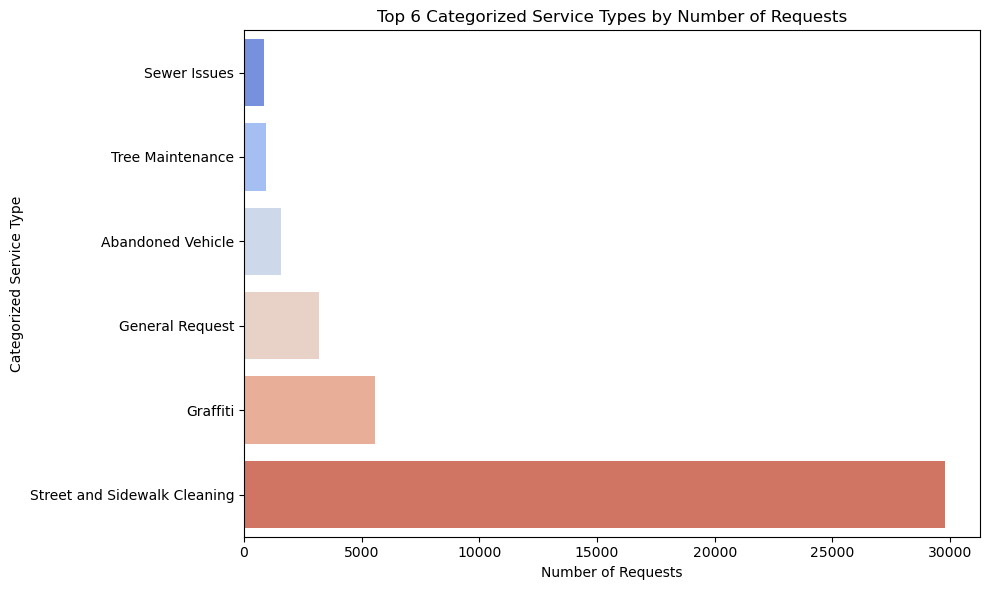

In [ ]:
# Apply the classify_service function and count occurrences
service_counts = df['service_name'].apply(classify_service).value_counts()

# Get the top 6 services and sort in ascending order for plotting purposes
top_6_service_counts = service_counts.nlargest(6).sort_values(ascending=True)

# Set the size of the plot
plt.figure(figsize=(10, 6))

# Create a horizontal bar plot for the top 6 services
sns.barplot(x=top_6_service_counts.values, y=top_6_service_counts.index, orient='h', palette='coolwarm')

# Add labels and title
plt.xlabel('Number of Requests')
plt.ylabel('Categorized Service Type')
plt.title('Top 6 Categorized Service Types by Number of Requests')

# Ensure the plot is displayed correctly with enough space for the labels
plt.tight_layout()

# Show the plot
plt.show()

The bar graph illustrates that "Street and Sidewalk Cleaning" is by far the most common service request, with a staggering 30,000 requests, which constitutes over 60% of the total service requests for November. This is a clear indication of its prominence in the dataset. Following far behind in frequency are "Graffiti" and "General Requests," each tallying over 5,000 and around 3,000 requests, respectively. The remaining categories, "Abandoned Vehicle," "Tree Maintenance," and "Sewer Issues," each have request counts at or below the 2,000 mark. Notably, these figures are set against a backdrop of 16 other service categories, which suggests a significant concentration of service needs within a few key areas.

##### **ii. Group by Supervisor District**

Now, we aim to identify the most frequent 311 services reported in November within each district. To achieve this, we'll undertake two steps. First, we'll calculate the total counts of services in each district. Then, we'll generate a separate summary table that outlines the number of reports for each service within each district, selecting the top three services based on their frequency. Subsequently, we will merge these two tables together, using the shared variable `supervisor_district`. 

This combined summary will provide an insight into both the overall service counts per district and the top three reported services within each district during November.

In [ ]:
# Group data by services and supervisor districts
grouped_data = df.groupby(['service_name', 'supervisor_district']).size().reset_index(name='count')

# Calculate the total count for each district
district_total_counts = grouped_data.groupby('supervisor_district')['count'].sum()

# Find the top 3 services with the maximum count for each district
top_services_per_district = (
    grouped_data.groupby('supervisor_district')
    .apply(lambda x: x.nlargest(3, 'count'))
    .reset_index(drop=True)
)

# Merge the top services with total counts for each district
top_services_per_district = top_services_per_district.merge(
    district_total_counts.reset_index(name='total_count'),
    on='supervisor_district',
    how='left'
)

# Display the top 3 services with maximum count for each district along with total counts
display(top_services_per_district)

,service_name,supervisor_district,count,total_count
0,Street and Sidewalk Cleaning,0,4,8
1,Graffiti,0,1,8
2,Noise Report,0,1,8
3,Street and Sidewalk Cleaning,1,2615,3660
4,Graffiti,1,186,3660
5,Abandoned Vehicle,1,137,3660
6,Street and Sidewalk Cleaning,2,2312,3680
7,Graffiti,2,344,3680
8,General Request - PUBLIC WORKS,2,132,3680
9,Street and Sidewalk Cleaning,3,4820,6869


The table provides a revealing snapshot of service request trends across different districts. The count column represents the frequency of each specific service requested within a district, whereas the total_count column reflects the aggregate number of service requests for that district.

"Street and Sidewalk Cleaning" emerges as the most commonly requested service citywide. "Graffiti Removal" is also prevalent, often ranked second, but much less requested compared to Street and Sidewalk Cleaning in most areas. "Abandoned Vehicle" reports also feature prominently, often ranking as the third most common request.

Districts exhibit similar service request patterns, suggesting civic needs across the city. The presence of different services in this top 3 list reflects varied civic concerns. Notably, Districts 3, 5, and 9 stand out with much higher total service requests compared to others, hinting at potential differences in population densities or distinct environmental conditions influencing service demands.

Understanding the disparities in service requests between districts is crucial for targeted resource allocation and service enhancements. Ultimately, this data emphasizes the importance of customizing civic services to meet the unique needs of each district, thereby optimizing resource distribution and service delivery.

#### **C. Temporal Trends in Service Requests**

Another key aspect to consider is the temporal pattern of these requests. We will now aim to generate a line graph displaying the daily request count trends throughout November. To achieve this, our approach involves computing the number of requests reported each day. This will be done by grouping the data by date and counting the occurrences of reports. Subsequently, using the `.pyplot` functions, we'll create a line graph illustrating these trends.

This visualization will enable us to discern the overall pattern of request counts throughout November and focus specifically on the Thanksgiving break period, encompassing dates from 11/22 to 11/26. By scrutinizing this interval, we aim to identify any notable patterns or variations during the Thanksgiving break compared to the general trend throughout the month.

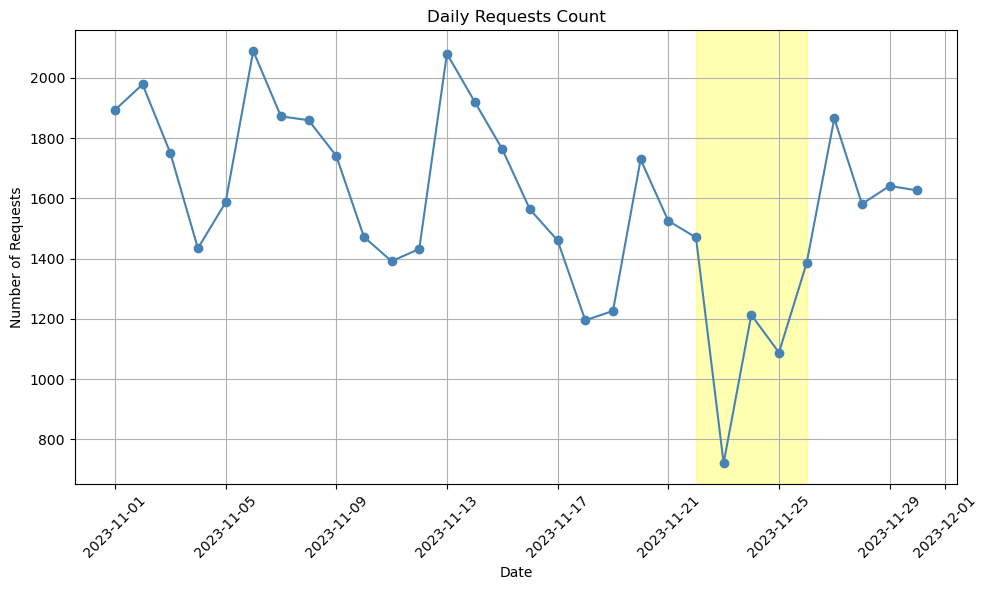

In [ ]:
# Group by date and count requests for each day
daily_requests = df.groupby(df['requested_datetime'].dt.date).size().reset_index(name='count')

# Plotting the data
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(daily_requests['requested_datetime'], daily_requests['count'], marker='o', linestyle='-', color='steelblue')

# Highlight the period from 11/22 to 11/26 represent Thanksgiving holiday
start_date = pd.to_datetime('2023-11-22')  
end_date = pd.to_datetime('2023-11-26')    
plt.axvspan(start_date, end_date, color='yellow', alpha=0.3)

# Set titles and labels
plt.title('Daily Requests Count')
plt.xlabel('Date')
plt.ylabel('Number of Requests')
plt.xticks(rotation=45)  

# Show grid and display the plot
plt.grid(True)
plt.tight_layout()
plt.show()

The line graph showcases substantial fluctuations in the number of requests, ranging from approximately 700 to 2,100. Notably, the data reflects a pattern where the count tends to peak considerably (around 2,000-2,100) on most Mondays, remarkably declines (often by 600-800) heading into the weekends then rebounds on Sundays.

During the break, similar trends are observed, yet the overall request counts notably decrease. Particularly on Thanksgiving Day (11/23), requests plummet to merely 700. Although there's a slight recovery the next day, the count remains relatively subdued compared to the pre-Thanksgiving period. Even post-Thanksgiving, request numbers persist at a lower level, with the peak on the following Monday (11/27) reaching just above 1800.

Following are insights from the data reveal:

1. **Weekly Patterns:** Requests peak on Mondays and decline toward weekends, indicating a potential relationship with work or weekday activities. This could imply that certain services are more in demand at the beginning of the week, possibly related to work-related or routine concerns.
  
2. **Thanksgiving Impact:** Sharp drop in requests during Thanksgiving suggests reduced civic concerns amid the holiday. This decrease might correlate with reduced routine activities, as people likely prioritize family gatherings and celebrations, leading to fewer reported civic concerns or service needs.
  
3. **Post-Holiday Recovery:** Slow return to normal request levels after Thanksgiving implies a lingering holiday effect on service needs. This indicates a potential lag in the resumption of routine service requests even after the holiday period concludes.

Understanding these trends aids in better resource allocation and service planning, emphasizing the influence of holidays on civic service utilization.

### **2. Resolve Time and Related Metrics**

In assessing the efficiency and effectiveness of service delivery, a critical factor to consider is the resolve time for each service request. This analysis helps in identifying areas where the service process can be optimized, leading to improved resident satisfaction and operational efficiency.

#### **A. Definition and Calculation of Resolve Time**

Resolve time is an essential metric for evaluating the efficiency and responsiveness of services. It measures the duration from the initiation of a service request to its resolution. More specifically, resolve time is the elapsed time between the logging of a request and the moment it is marked as resolved. This metric is key in assessing how quickly different services respond to and resolve issues.

##### **i. Data Selection and Preparation**

In our analysis, we've made a strategic decision to exclude the `closed_date` column from our filtered dataset. This choice is informed by the observation that `closed_date` often mirrors the value in `updated_datetime`, especially when the `status_description` of a request is marked as 'closed'. In instances where the request is not closed, `closed_date` typically lacks a value, leading to missing data concerns. By omitting this column, we streamline our dataset and avoid complexities associated with handling missing values.

##### **ii. Focusing on Closed Cases**

For a precise analysis of resolve time, our attention is directed towards service requests that are conclusively closed or resolved. This focused approach allows for a more accurate assessment of the time involved in resolving each request. To achieve this, we filter our dataset to include only those requests where the `status_description` is 'Closed'.

##### **iii. Analyzing Service Request Proportions**

An initial step in our analysis is understanding the proportion of closed versus open service requests within our dataset. This is accomplished through the following code:

In [ ]:
# Grouping the DataFrame by 'status_description' column
grouped_by_status = df.groupby('status_description')

# Counting the number of entries in each group
status_counts = grouped_by_status.size()

# Displaying the counts for each status
print(status_counts)

status_description
Closed    41968
Open       5582
dtype: int64


From this analysis, we find that in the month of November, up to the most recent data point, there were 41,969 cases (approximately 88.26%) marked as 'Closed' and 5,582 cases (about 11.74%) marked as 'Open'.

##### **iv. Creating a Resolved Cases Dataset**

To delve deeper into service delivery efficiency, our primary focus is on the 'Closed' cases, which total 41,969. Our aim is to investigate the average duration required for these service requests to be processed and resolved.

We begin by creating a new subset from our original dataset, specifically including only those cases marked as 'Closed'. This selective process ensures that our analysis is based on completed requests, providing relevant and accurate insights into the resolution process.

##### **v. Introducing the `resolution_time` Variable**

To quantify the resolution duration, we introduce a new variable, `resolution_time`, in our subset dataset. This variable is calculated as the difference between the `updated_datetime` and the `requested_datetime` for each service request. This calculation offers us a measure of the time taken for each request from initiation to closure.

The implementation of this calculation can be visualized through the following code:

In [ ]:
# Creating a copy of the subset of the DataFrame where 'status_description' is 'Closed'
resolved_data = df[df['status_description'] == 'Closed'].copy()

# Calculating the 'resolution_time'
resolved_data['resolution_time'] = resolved_data['updated_datetime'] - resolved_data['requested_datetime']

# Displaying descriptive statistics of 'resolution_time'
resolved_data['resolution_time'].describe()

count                        41968
mean     2 days 01:00:36.002239801
std      4 days 01:54:44.758506749
min              -1 days +05:59:00
25%                0 days 01:23:34
50%         0 days 13:31:14.500000
75%         1 days 23:15:39.500000
max               36 days 15:57:16
Name: resolution_time, dtype: object

Among the 41,969 closed cases analyzed, the average resolution time was found to be approximately 2 days. This average, however, is accompanied by a notably high standard deviation of about 4 days and 2 hours, reflecting substantial variability in resolution times across different cases.

A point of concern arises with the observation of the minimum recorded resolution time, which is anomalously at -1 day, 5 hours, and 59 minutes. This negative duration is clearly atypical and strongly indicates a discrepancy, possibly due to errors in data entry or a flaw in timestamp recording. It suggests that, in certain instances, the 'resolved' timestamp was erroneously logged before the 'initiated' timestamp.

Looking more closely at the distribution of resolution times, we find that 25% of the service requests were resolved in 1 hour and 23 minutes or less, indicating that a significant proportion of requests are addressed quite rapidly. The median resolution time, a more robust indicator than the mean in this context, stands at approximately 13 hours and 31 minutes. This median value suggests that more than half of the service requests are resolved within a relatively short duration. 

Furthermore, the data shows that 75% of the requests are resolved within about 1 day and 23 hours, demonstrating that the majority of cases are managed within a two-day timeframe. On the other end of the spectrum, the longest resolution time recorded extends to 36 days and around 16 hours, highlighting that a small fraction of cases experience considerably extended resolution periods.

In the context of SF311, which handles non-emergency cases, the average resolution time of 2 days generally aligns with reasonable expectations. However, the presence of some cases with excessively prolonged resolution times, as well as others that remain unresolved (as indicated by a `status_description` of 'Open'), warrants attention. These outliers suggest areas where the service delivery process may benefit from further review and potential improvements to ensure more consistent and timely resolutions across all types of requests.

#### **B. Resolve Time Across Difference Section**

Understanding the efficiency and effectiveness of service delivery becomes more nuanced when we segment the analysis of resolve times across different service categories. This approach allows for a detailed examination of how each type of service performs in terms of resolution efficiency, shedding light on areas that may need improvement or are performing exceptionally well.

##### **i. Categorized by Service Type**

To begin this in-depth analysis, we categorize service requests by their type. This categorization is pivotal as it enables us to compare the efficiency of resolution times across various service categories, thereby revealing the unique operational dynamics of each.

Utilizing a `classify_service` function on the `service_name` column of our dataset, we simplify the data by grouping services into broader categories. For instance, services beginning with 'General Request' are classified under one umbrella category, while others retain their specific service names. This step is crucial for highlighting broad trends and patterns that might be less apparent at a granular level.

With the services categorized, we employ Pandas' `.groupby` and `.agg` functions to compute essential statistical measures for each service category. These measures include the mean, median, standard deviation, minimum, and maximum resolve times. We also account for the number of requests in each category, providing insight into the demand and associated workload.

The results of this analysis present a comprehensive overview of service resolution efficiency across categories, pinpointing which are resolved swiftly, which tend to have longer resolution times, and the variance within each category. This insight is invaluable for identifying categories that are either overburdened or highly efficient, guiding strategic resource allocation and decision-making processes.

Here is the implementation of this categorization and analysis:

In [ ]:
# Apply the classify_service function to categorize services
resolved_data['categorized_service'] = resolved_data['service_name'].apply(classify_service)

# Group by the new categorized service name and calculate resolve time statistics
resolve_time_by_service = resolved_data.groupby('categorized_service')['resolution_time'].agg(['count', 'mean', 'median', 'std', 'min', 'max'])
resolve_time_by_service

,count,mean,median,std,min,max
categorized_service,,,,,,
311 External Request,104,3 days 01:54:12.326923076,1 days 06:27:00,5 days 10:59:19.135600591,0 days 00:05:00,30 days 13:52:04
Abandoned Vehicle,1557,6 days 00:06:56.108542068,5 days 04:33:28,5 days 03:09:10.223539497,0 days 00:01:01,29 days 14:26:36
Blocked Street or SideWalk,147,4 days 04:45:51.979591836,2 days 07:45:41,5 days 08:06:24.732187187,0 days 00:11:48,26 days 18:43:00
Catch Basin Maintenance,36,2 days 02:55:10.138888888,0 days 21:01:55,3 days 14:43:53.788813369,0 days 00:52:00,20 days 04:26:00
Damaged Property,375,6 days 04:08:36.610666666,3 days 23:01:00,5 days 03:04:51.845486127,0 days 00:03:00,17 days 11:48:07
Encampments,136,0 days 12:32:52.176470588,0 days 02:30:00,2 days 02:54:09.780978288,0 days 00:02:10,24 days 10:43:00
General Request,2697,2 days 09:45:10.597701149,0 days 17:58:42,4 days 07:31:57.638544920,0 days 00:00:23,34 days 23:49:48
Graffiti,2985,6 days 14:22:15.980234505,3 days 06:18:29,7 days 20:26:44.932553302,-1 days +05:59:00,34 days 19:13:54
Homeless Concerns,2,0 days 00:11:33,0 days 00:11:33,0 days 00:03:43.445742854,0 days 00:08:55,0 days 00:14:11


***Highlights from the Analysis:***

1. **Wide Variability in Average Resolve Times**: There's a significant variation in average resolve times across different service categories. For example, 'Abandoned Vehicle', 'Graffiti', and 'Damaged Property' requests take around 6 days on average to resolve, which is notably higher than categories like 'Sewer Issues' resolved typically in less than a day.

2. **High Standard Deviation in Some Categories**: Categories like 'Graffiti' and 'Blocked Street or SideWalk' exhibit high standard deviations, indicating a wide range of resolve times within these categories. This variability suggests inconsistency in how quickly different cases within the same category are addressed.

3. **Negative Minimum Resolve Times**: The negative minimum resolve times in categories like 'Graffiti' and 'Street and Sidewalk Cleaning' are unusual. These likely indicate data entry errors or issues with timestamp recording, as it's not feasible to have a negative resolve time.

4. **Extremely Long Maximum Resolve Times**: Some categories show exceptionally long maximum resolve times, such as 36 days in 'Rec and Park Requests'. These outliers could be due to complex cases requiring extended resolution time or could indicate bottlenecks in the process.

5. **Quick Resolutions in Certain Categories**: Categories like 'Sewer Issues' and 'Homeless Concerns' have relatively short median resolve times. This suggests a quicker response and resolution process, possibly due to the urgency or streamlined procedures for these types of requests.

6. **Large Volume of Requests in Some Categories**: 'Street and Sidewalk Cleaning' shows a significantly higher count of requests (29,218 cases) compared to other categories, which might impact the average resolve time due to the volume of cases handled.

The insights gleaned from this segmented analysis are invaluable in forming a comprehensive understanding of service delivery performance. By dissecting the resolve times across different service categories, we can pinpoint specific areas that excel and others that may require targeted interventions. This level of detail in the analysis is instrumental for developing tailored strategies that not only address inefficiencies but also optimize resource allocation. Ultimately, such a methodical approach paves the way for significant enhancements in service effectiveness in the area.

##### **ii. Geographical Segmentation**


Following this, we aim to uncover the patterns within resolution times among various geographical segments, specifically focusing on the districts within San Francisco. 

To achieve this, we employ the `.groupby` function to group the data according to the 'supervisor_district' column. Subsequently, we utilize `.agg` to aggregate different statistical measures ('count', 'mean', 'median', 'std', 'min', 'max') derived from the data. 

This approach allows us to glean insights into the distribution of resolution times across different supervisor districts within San Francisco, shedding light on trends and variations in how efficiently cases are resolved within each specific district. By grouping the data and aggregating statistical measures, we seek to discern patterns, potential outliers, and disparities in resolution times among these geographical segments, offering a comprehensive understanding of the efficiency and effectiveness of issue resolution within each district in San Francisco.

In [ ]:
# Group by geographical area and calculate resolve time statistics
resolve_time_by_area = resolved_data.groupby('supervisor_district')['resolution_time'].agg(['count', 'mean', 'median', 'std', 'min', 'max'])
resolve_time_by_area

,count,mean,median,std,min,max
supervisor_district,,,,,,
0,6,1 days 00:32:32,0 days 11:29:21.500000,1 days 05:28:01.895744749,0 days 00:32:17,2 days 23:45:00
1,3406,1 days 05:54:55.782149148,0 days 05:11:01,2 days 22:27:52.858124474,0 days 00:00:08,31 days 21:55:00
2,3298,1 days 17:33:06.814736203,0 days 07:36:26.500000,3 days 22:21:10.290054427,-1 days +05:59:00,33 days 14:22:22
3,6069,1 days 20:15:22.366287691,0 days 13:03:00,3 days 18:10:37.867283785,0 days 00:00:14,33 days 01:12:07
4,2362,1 days 19:39:47.169348010,0 days 07:41:35.500000,3 days 17:07:50.978782631,0 days 00:00:15,30 days 13:51:05
5,5874,2 days 08:27:53.042560435,0 days 15:10:30,4 days 19:00:23.026990950,-1 days +05:59:00,36 days 01:05:00
6,3504,2 days 14:41:03.853310502,0 days 19:54:32,4 days 14:43:36.169175508,-1 days +07:59:00,35 days 17:29:00
7,2167,2 days 03:00:00.330872173,0 days 11:37:13,3 days 20:11:50.239787430,0 days 00:00:14,32 days 01:06:00
8,3085,2 days 06:44:04.273581847,0 days 17:13:16,4 days 00:18:18.978780335,0 days 00:00:17,36 days 15:57:16


***Insights derived from the geographical segmentation summary:***

1. **Diverse Resolution Times Across Districts:** Noticeable variability exists in resolution times among different supervisor districts. Some districts demonstrate notably shorter resolution times compared to others, with median durations ranging between 5 to 17 hours and average durations spanning 1 to 2 days.

2. **Districts 1 & 11: Shorter Resolution Times:** Districts 1 and 11 showcase comparatively lower median (5 and 9 hours) and mean (around 1 day 5 hours and 1 day 15 hours) resolution times compared to other districts. This suggests more efficient or streamlined processes in resolving cases within these areas.

3. **Districts 5 & 6: Extended Resolution Times:** Districts 5 and 6 exhibit longer median (15 and 19 hours) and mean (2 days 8 hours and 2 days 14 hours) resolution times compared to most other districts. Higher standard deviations and maximum durations in these areas also imply potential complexities in addressing issues, requiring additional time for resolution.

4. **Outliers and Anomalies**: Some districts have anomalies or outliers in their data, such as negative resolution times (anomalies) or exceptionally long resolution times (outliers), which can be found in the `min` and `max` columns. These anomalies could indicate data entry errors or unusual cases that might need further investigation or validation.

5. **Standard Deviation Variations:** Standard deviation reflects the spread of resolution times within districts. Higher standard deviations indicate greater variability or inconsistency in resolution times within those areas.

6. **Potential for Process Enhancement:** Examining districts with shorter resolution times may provide insights into effective strategies adaptable to other districts, fostering more efficient issue resolution. Conversely, districts with longer resolution times could benefit from process improvements to expedite case resolution.

7. **Service Level Discrepancies:** Variation in resolution times might indicate disparities in service levels or resource allocation across districts. Addressing these differences could facilitate optimized resource distribution, ensuring consistent service quality throughout all districts.

These insights form the foundation for deeper exploration, seeking to understand the specific factors influencing varied resolution times among supervisor districts. Each district's unique characteristics necessitate tailored strategies to enhance service delivery effectiveness and equity.

## **VII. Conclusion**

In conclusion, our comprehensive analysis unveils critical insights across various dimensions:

1. **Service Requests Overview and Trends:**
   - The diversity of service requests, ranging from street cleaning to specific concerns like graffiti or homeless issues, highlights the multifaceted nature of community needs.
   - 'Street and Sidewalk Cleaning' dominate, comprising over 60% of total requests, indicating its significance in the dataset. 'Graffiti' and 'General Request' follow with substantial, yet lesser, frequencies.
   - Temporally, requests peak on Mondays and decline towards weekends. During Thanksgiving, a notable drop in requests is observed, persisting post-holiday before a slow return to normal levels.

2. **Resolve Time Analysis:**
   - Categories exhibit wide variations in average resolve times, with 'Abandoned Vehicle' and 'Graffiti' requests taking notably longer compared to 'Sewer Issues.'
   - Some categories show high standard deviations, suggesting inconsistency in resolving cases within the same category.
   - Anomalies like negative resolve times in 'Graffiti' and 'Street and Sidewalk Cleaning' indicate possible data entry issues.
   - Certain categories display exceptionally long maximum resolve times, potentially indicating complex cases or process bottlenecks.
   - Geographical segmentation highlights varying resolution times across districts, with Districts 1 and 11 showing shorter durations and Districts 5 and 6 indicating longer resolution times. Anomalies and disparities in service levels are also observed across districts.

These insights signify the importance of understanding service request patterns, temporal trends, and the variability in resolution times among different categories and geographical segments. The findings serve as a foundation for enhancing service delivery, optimizing resource allocation, and addressing disparities across supervisor districts in San Francisco.

## **VIII. Reference**

- San Francisco 311 Cases Dataset: [SFGov - 311 Cases](https://data.sfgov.org/City-Infrastructure/311-Cases/vw6y-z8j6/about_data)
- San Francisco DataSF - 311 Case Data FAQ: [Datasf - 311 Case Data FAQ](https://support.datasf.org/help/311-case-data-faq)
- Socrata API Documentation - Retrieving more than 1000 records: [Socrata API Limit](https://support.socrata.com/hc/en-us/articles/202949268-How-to-query-more-than-1000-rows-of-a-dataset)
- Pandas Documentation - Nullable Data Type: [Pandas Nullable Data Type](https://pandas.pydata.org/docs/user_guide/integer_na.html)
- Pandas Data Manipulation - Deleting Rows and Columns: [Deleting Rows and Columns in Pandas](https://www.shanelynn.ie/pandas-drop-delete-dataframe-rows-columns/)